## Train sea lion classifier with a convnet

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/02/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/05/'
#IMAGE_DIMS = (148,148,3)
IMAGE_DIMS = (84,84,3)
#IMAGE_DIMS = (32,32,3)

INPUT_DATASET_NAME = 'lion-patches-30px'
SAVE_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights.h5'
LOAD_WEIGHTS_FILE = None

BATCH_SIZE=24

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

import keras
from keras.preprocessing.image import ImageDataGenerator

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions

Using TensorFlow backend.


## Prepare

### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, dirs=['tf-logs','weights'], recreate=False)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
TF_LOGS_DIR = OUTPUT_DIR + 'tf-logs/'
WEIGHTS_DIR = OUTPUT_DIR + 'weights/'
input_dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)

logger.info('Output dirs created')

2017-04-15 21:38:03,779 INFO Output dirs created


### Prepare CNN model

In [4]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)
model = lions.convnet_simple_lion_keras(IMAGE_DIMS)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2017-04-15 21:38:03,786 INFO Load CNN model


### Prepare train, validate and test data flows

In [5]:
logger.info('Using dataset ' + input_dataset_path + ' as input')
h5file = h5py.File(input_dataset_path, 'r')

logger.info('train data')
train_batch_generator = utils.BatchGeneratorXYH5(h5file)

logger.info('train size=' + str(train_batch_generator.size) + ' batches=' + str(train_batch_generator.nr_batches))

image_randomize_generator = ImageDataGenerator(
        featurewise_center=True,
        samplewise_center=False,
        featurewise_std_normalization=True,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=360,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=False,
        vertical_flip=False)

train_balance_generator = utils.ClassBalancerGeneratorXY(train_batch_generator,
                                                         image_augmentation=image_randomize_generator,
                                                         output_weight=(1,1,1,1,1,1),
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False)

train_balance_generator.setup_flow(0.5, 0.51)
train_generator = utils.image_augmentation_xy(train_balance_generator.flow(), image_randomize_generator)

logger.info('validate data')
validate_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.99, end_ratio=1, batch_size=BATCH_SIZE)
logger.info('validate size ' + str(validate_batch_generator.size) + ' ' + str(validate_batch_generator.nr_batches))
validate_generator = validate_batch_generator

2017-04-15 21:38:03,974 INFO Using dataset ../../input/kaggle-sea-lion/02/lion-patches-30px-84-84.h5 as input
2017-04-15 21:38:03,977 INFO train data
2017-04-15 21:38:03,979 INFO train size=74328 batches=1162
2017-04-15 21:38:03,980 INFO loading input data for class distribution analysis...
2017-04-15 21:38:03,982 INFO > [started] generator dump...


74328/74328

2017-04-15 21:38:18,384 INFO > [done]    generator dump (14401.943 ms)
2017-04-15 21:38:18,425 INFO raw sample class distribution
2017-04-15 21:38:18,426 INFO 0: 4680
2017-04-15 21:38:18,428 INFO 1: 3534
2017-04-15 21:38:18,429 INFO 2: 17903
2017-04-15 21:38:18,431 INFO 3: 8577
2017-04-15 21:38:18,432 INFO 4: 6597
2017-04-15 21:38:18,433 INFO 5: 33037
2017-04-15 21:38:18,434 INFO overall output samples per class: 3534
2017-04-15 21:38:18,436 INFO augmentation/undersampling ratio per class
2017-04-15 21:38:18,437 INFO SETUP FLOW 0 1
2017-04-15 21:38:18,438 INFO output distribution
2017-04-15 21:38:18,440 INFO 0: 0.755128205128 (3534.0)
2017-04-15 21:38:18,441 INFO 1: 1.0 (3534.0)
2017-04-15 21:38:18,442 INFO 2: 0.197397084288 (3534.0)
2017-04-15 21:38:18,443 INFO 3: 0.412032179084 (3534.0)
2017-04-15 21:38:18,444 INFO 4: 0.535698044566 (3534.0)
2017-04-15 21:38:18,446 INFO 5: 0.106970971941 (3534.0)
2017-04-15 21:38:18,447 INFO output total size 21204.0
2017-04-15 21:38:18,448 INFO flow

2017-04-15 21:38:18,646 INFO INPUT DATASET DATA
2017-04-15 21:38:18,648 INFO generator
2017-04-15 21:38:18,651 INFO > [started] generator dump...


64/38

2017-04-15 21:38:18,666 INFO > [done]    generator dump (15.190 ms)
2017-04-15 21:38:18,667 INFO showing 38 images
2017-04-15 21:38:18,670 INFO > [started] generating image patches. rows=4; cols=10...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/utils.py:554: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(image_labels!=None):


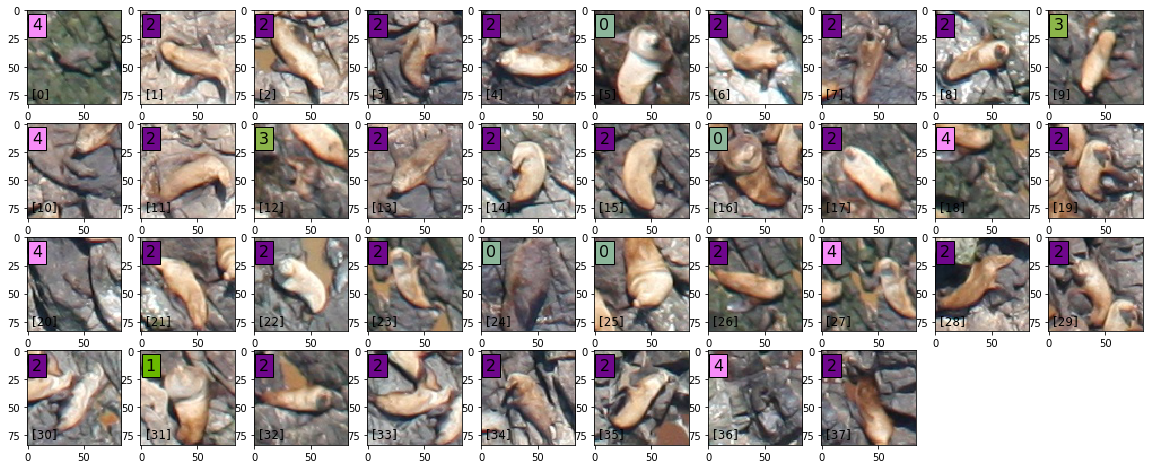

2017-04-15 21:38:23,261 INFO > [done]    generating image patches. rows=4; cols=10 (4591.203 ms)
2017-04-15 21:38:23,265 INFO x (38, 84, 84, 3)
2017-04-15 21:38:23,271 INFO y (38, 6)
2017-04-15 21:38:23,273 INFO [ 4  1 25  2  6  0]
2017-04-15 21:38:23,274 INFO BALANCE GENERATOR DATA
2017-04-15 21:38:23,276 INFO > [started] generator dump...
2017-04-15 21:38:23,277 INFO starting new flow...


256/212

2017-04-15 21:38:23,458 INFO > [done]    generator dump (182.126 ms)
2017-04-15 21:38:23,460 INFO x (212, 84, 84, 3)
2017-04-15 21:38:23,461 INFO y (212, 6)
2017-04-15 21:38:23,463 INFO [42  8 58 11 93  0]
2017-04-15 21:38:23,466 INFO starting new flow...
2017-04-15 21:38:23,516 INFO showing 64 images
2017-04-15 21:38:23,518 INFO > [started] generating image patches. rows=7; cols=10...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/utils.py:534: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(group_by_label==True and image_labels!=None):


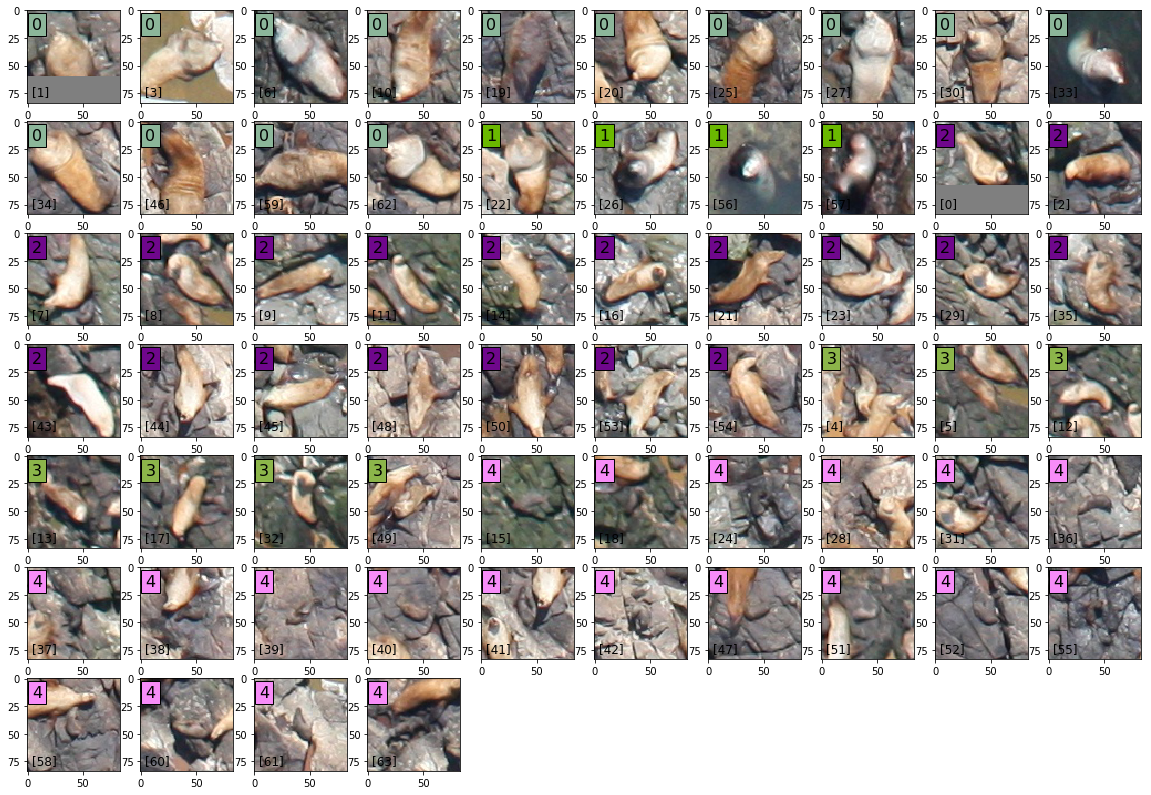

2017-04-15 21:38:31,307 INFO > [done]    generating image patches. rows=7; cols=10 (7788.154 ms)


In [6]:
logger.info('INPUT DATASET DATA')
dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
with h5py.File(input_dataset_path, 'r') as h5file:
#    logger.info('dataset')
#    utils.show_images(h5file['X'][37:74], image_labels=utils.onehot_to_label(h5file['Y'][37:74]), group_by_label=False, cols=10, is_bgr=True, size=2)

    logger.info('generator')
    input_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.0005, end_ratio=0.001, batch_size=64)
    X, Y = utils.dump_xy_to_array(input_generator.flow(), input_generator.size, x=True, y=True)
    utils.show_images(X, image_labels=utils.onehot_to_label(Y), group_by_label=False, cols=10, is_bgr=True, size=2)

    logger.info('x ' + str(np.shape(X)))
    logger.info('y ' + str(np.shape(Y)))
    logger.info(str(utils.class_distribution(Y)))

logger.info('BALANCE GENERATOR DATA')
dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
X_train, Y_train = utils.dump_xy_to_array(train_balance_generator.flow(), train_balance_generator.size, x=True, y=True)
logger.info('x ' + str(np.shape(X_train)))
logger.info('y ' + str(np.shape(Y_train)))
logger.info(str(utils.class_distribution(Y_train)))

c = 0
for xs,ys in train_balance_generator.flow():
    if(c>=1):
        break
    c += 1
    utils.show_images(xs, image_labels=utils.onehot_to_label(ys), cols=10, is_bgr=True, size=2)
#    for i,x in enumerate(xs):
#        if(c>=3):
#            break
#       print('Y: ' + str(ys[i]))
#        print('X: ' + str(np.shape(x)))
#        utils.show_image(x, is_bgr=True)


## Train model

In [7]:
if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    logger.info('Loading previous weights...')
    model.load_weights(WEIGHTS_FILE)

logger.info('Starting CNN training...')

history = model.fit_generator(train_generator,
              steps_per_epoch = train_balance_generator.nr_batches,
              nb_epoch = 1, 
              callbacks = cnn.get_callbacks_keras(model, WEIGHTS_DIR, TF_LOGS_DIR),
              validation_data = validate_generator.flow(), 
              validation_steps = validate_generator.nr_batches,
              verbose = 1)

if(SAVE_WEIGHTS_FILE!=None):
    logger.info('Saving last weights...')
    model.save_weights(SAVE_WEIGHTS_FILE)

2017-04-15 21:38:31,378 INFO Starting CNN training...
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_steps=31, callbacks=None, epochs=1, steps_per_epoch=4, validation_data=<generator..., verbose=1)`
2017-04-15 21:38:32,067 INFO starting new flow...


Epoch 1/1


/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:500: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:508: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


4/4 [==============================] - 19s - loss: 1.6040 - acc: 0.3086 - val_loss: 2.3505 - val_acc: 0.0296

2017-04-15 21:38:51,108 INFO Saving last weights...


### Epoch accuracy/loss

2017-04-15 21:38:51,336 INFO Training info


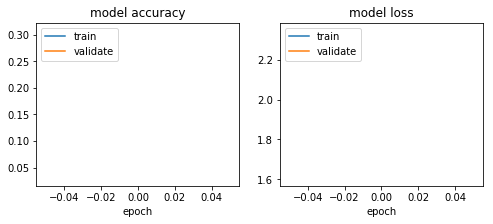

In [8]:
logger.info('Training info')
cnn.show_training_info_keras(history)

### Confusion matrix

2017-04-15 21:38:51,703 INFO Evaluating model performance (744 samples)...
2017-04-15 21:39:00,684 INFO Accuracy: 0.0786666681369 - Loss: 2.53767845154
2017-04-15 21:39:00,686 INFO Predicting Y for detailed analysis...
2017-04-15 21:39:09,833 INFO > [started] generator dump...


750/744

2017-04-15 21:39:10,108 INFO > [done]    generator dump (275.866 ms)
2017-04-15 21:39:10,110 INFO Nr test samples: 744|744
2017-04-15 21:39:10,112 INFO Kappa score (was this luck?): 0.0
2017-04-15 21:39:10,116 INFO Confusion matrix:
2017-04-15 21:39:10,117 INFO [[ 59   0   0   0   0   0]
 [ 28   0   0   0   0   0]
 [146   0   0   0   0   0]
 [ 38   0   0   0   0   0]
 [107   0   0   0   0   0]
 [366   0   0   0   0   0]]


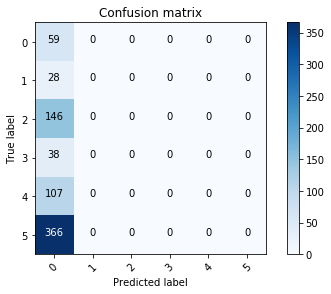

In [9]:
from sklearn import metrics
dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
with h5py.File(input_dataset_path, 'r') as h5file:
    test_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.7, end_ratio=0.71, batch_size=10)
    cnn.evaluate_dataset_keras(test_batch_generator.flow(), test_batch_generator.nr_batches, test_batch_generator.size, model)

In [10]:
s = slice(0,1)
a = np.zeros((2,2), dtype='uint8')
print(a[s,s])

[[0]]
